In [ ]:
!pip install transformers

In [ ]:
import torch
from torch import nn
import torchtext
import numpy as np
import random, time, json
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print(torch.__version__)
print(torchtext.__version__)

2.0.1+cu118
0.15.2+cpu


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Dataset

## Downloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# COPYING KAGGLE API CREDENTIALS FROM GOOGLE DRIVE TO LOAD REVIEWS DATASET FROM KAGGLE
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/docs/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d bittlingmayer/amazonreviews
! unzip amazonreviews.zip -d data/

amazonreviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazonreviews.zip
replace data/test.ft.txt.bz2? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/train.ft.txt.bz2? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
TRAIN_PATH = "/content/data/train.ft.txt.bz2"
TEST_PATH = "/content/data/test.ft.txt.bz2"

## Loading data with filter

In [ ]:
MIN_LEN_ALLOWED = 3     # select review that has more than MIN_LEN_ALLOWED words
MAX_LEN_ALLOWED = 60    # select review that has less than MAX_LEN_ALLOWED words
N_TRAIN = 10_000     # maximum number of training samples to select
N_TEST = 2500        # maximum number of test samples to select
# N_TRAIN = 1_000     # maximum number of training samples to select
# N_TEST = 250

In [ ]:
# since we have large dataset of 3.6 million reviews, we will filter only a few using this function
def text_filter(text):
    alpha = "abcdefghijklnopqrstuvwxyz "
    text = "".join([i for i in text.lower().strip() if i in alpha])
    text_len = len(text.split())
    return text_len >= MIN_LEN_ALLOWED - 1 and text_len <= MAX_LEN_ALLOWED

In [ ]:
import bz2

# thsi function reads data from the file and selects the line that passes through the filter function
def extract_content(file_path, N=None):
    data = []
    with bz2.open(file_path, 'rt') as f:
        with tqdm(total=N) as pbar:
            while (line := f.readline()):
                line = f.readline()
                label = int(line[9])
                text = line[11:]
                if text_filter(text):
                    data.append(
                        [label, text]
                    )
                    pbar.update(1)
                if pbar.n == N: break

    return data

In [ ]:
train = extract_content(TRAIN_PATH, N=N_TRAIN)

100%|██████████| 10000/10000 [00:05<00:00, 1940.70it/s]


In [ ]:
test = extract_content(TEST_PATH, N=N_TEST)

100%|██████████| 2500/2500 [00:01<00:00, 2297.19it/s]


In [ ]:
# this function balances the dataset such that each of the 2 classes has equal number of samples in train dataset

def equalize_labels(data):
    # Count the number of tuples with label 1 and label 2
    count_1 = sum(1 for item in data if item[0] == 1)
    count_2 = sum(1 for item in data if item[0] == 2)

    # Determine the minimum count between label 1 and label 2
    min_count = min(count_1, count_2)

    # Collect tuples with label 1 and label 2 up to the minimum count
    new_data = [item for item in data if item[0] == 1][:min_count]
    new_data += [item for item in data if item[0] == 2][:min_count]

    # shuffling the data
    random.shuffle(new_data)

    return new_data

In [ ]:
train = equalize_labels(train)

In [ ]:
N_TRAIN = len(train)
N_TEST = len(test)

print("Total Train Samples:", N_TRAIN)
print("Total TEST Samples:", N_TEST)

Total Train Samples: 8932
Total TEST Samples: 2500


In [ ]:
train[0], test[0]

([1,
  'Waste of Money: We purchased this product because of its filteration system claiming it would help eliminate hard water stains on our shower doors and walls. It does not work at all and the design of the shower head is ugly. The product was delivered as promissed but without any return address or customer service information.\n'],
 [2,
  "works fine, but Maha Energy is better: Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries.\n"])

## Description of Data
- Distribution of Number of words in each sentence
- Label Distribution
    - 1: Negative Sentiment
    - 2: Positive Sentiment

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_length_distribution(data, name, ax):
    data = [len(i[1].split(" ")) for i in data]
    sns.histplot(data, bins=MAX_LEN_ALLOWED-MIN_LEN_ALLOWED, color='skyblue', edgecolor='white', ax=ax)
    ax.set_xlabel('Length of Sentences')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Length of Sentences in {name} Data')

def plot_label_distribution(data, name, ax):
    data = pd.Series([i[0] for i in data])
    data = data.value_counts()
    data.plot(kind='bar', title=f"Label Distribution in {name} Data", color="skyblue", ax=ax)

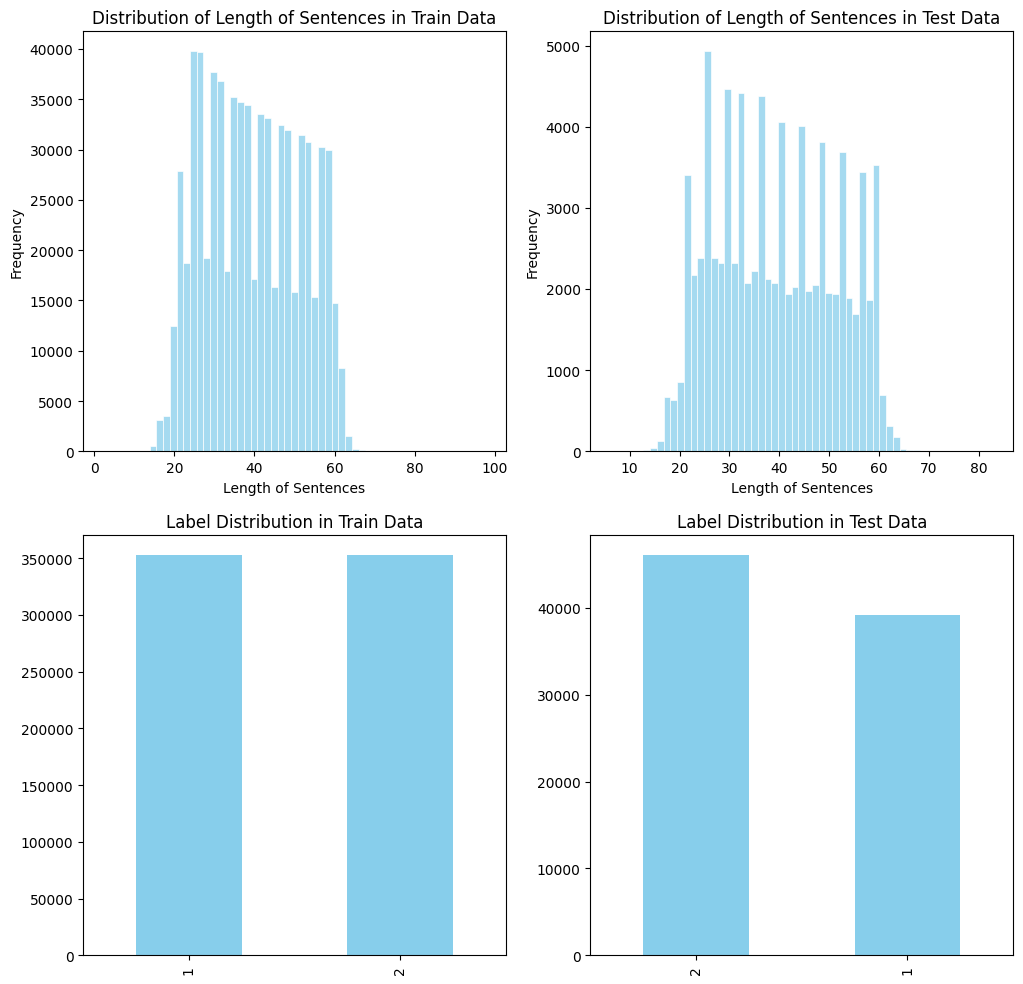

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

plot_length_distribution(train, name="Train", ax=axes[0][0])
plot_length_distribution(test, name="Test", ax=axes[0][1])
plot_label_distribution(train, name="Train", ax=axes[1][0])
plot_label_distribution(test, name="Test", ax=axes[1][1])

## Dataloader

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("StatsGary/setfit-ft-sentinent-eval")

tokenizer([
    "hello from other side",
    "hi"
], padding=True, truncation=True, return_tensors="pt")

{'input_ids': tensor([[   0, 7596, 2017, 2064, 2221,    2],
        [   0, 7636,    2,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0]])}

In [ ]:
# this function is called when a batch is generated in from DataLoader
def collate_batch(batch):
    time_i = time.time()
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label - 1)
        text_list.append(_text.lower())

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_encoded = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
    tokens = text_encoded['input_ids']
    masks = text_encoded['attention_mask']

    return tokens.to(DEVICE), masks.to(DEVICE), label_list.to(DEVICE)

# this function decides how to split the dataset into batches, here sentences of similar lengths are kept in a batch together
class SortedSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size, shuffle_times):
        self.batch_size = batch_size
        self.shuffle_times = shuffle_times

        # getting sorted index
        self.idx = [i[0] for i in sorted(enumerate(data_source), key=lambda x: len(x[1]))]

    def shuffle_idx(self):
        # starting points for each batch
        offsets = list(range(0, len(self.idx), self.batch_size))[:-1]
        # shuffling inter-batch
        for i in range(self.shuffle_times):
            i1, i2 = random.choices(offsets, k=2)
            self.idx[i1:i1+self.batch_size], self.idx[i2:i2+self.batch_size] = self.idx[i2:i2+self.batch_size], self.idx[i1:i1+self.batch_size]

    def __iter__(self):
        return iter(self.idx)

    def __len__(self):
        return len(self.idx)

# Modelling

## Utilities

In [ ]:
import torch.nn.functional as F

def accuracy(predictions, targets):
    # Apply softmax to the predictions to obtain probabilities
    probabilities = F.softmax(predictions, dim=1)

    # Convert probabilities to binary predictions
    _, predicted_labels = torch.max(probabilities, dim=1)

    # Compare predicted labels with target labels to calculate accuracy
    correct_predictions = torch.eq(predicted_labels, targets).sum().item()
    total_predictions = targets.size(0)
    accuracy = correct_predictions / total_predictions

    return accuracy

def predict_texts(texts, _print=True):

    tokens, masks, y = collate_batch(
        [[0, text.lower()] for text in texts]
    )
    model.eval()
    preds = model(tokens, attention_mask=masks).logits[:, 1]
    preds = preds.tolist()

    if _print:
        for pred, orig_text in zip(preds, texts):
            print(f"{int(round(pred))} ({round(pred, 3)}) - {orig_text}")
    else:
        return preds

def plot_history(history, skip_keys=[], splits=1, figsize=None):

    if figsize == None: figsize = (15, 15//len(history))
    fig, axs = plt.subplots(1, len(history), figsize=figsize)

    for i, (_key, _val) in enumerate(history.items()):
        for key, val in _val.items():
            if key in skip_keys: continue
            # creating splits
            val = torch.tensor(val)
            val = val[:(len(val) // splits) * splits].view(splits, -1).mean(axis=1)
            axs[i].plot(val, label=key)
        axs[i].legend()
        axs[i].set_title(_key)

    plt.show()

## Training

In [ ]:
# DATA PARAMETERS
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
TRAIN_ITERATIONS_PER_EPOCH = N_TRAIN // BATCH_SIZE
TEST_ITERATIONS_PER_EPOCH = N_TEST // TEST_BATCH_SIZE
SHUFFLE_TIMES = 50000
# TRAINGING PARAMETERS
EPOCHS = 1
LR = 0.01
MOMENTUM = 0
SCHEDULER_STEP_SIZE = 1
SCHEDULER_FACTOR = 0.8
# TESTING PARAMETERS
INFO_SPLIT = 100
TEST_SENTENCES = [
    # negative sentences
    "I'm extremely disappointed with the quality of this item; it broke within a week.",
    "The customer support for this product is terrible; they were unhelpful and rude.",#
    "I had high expectations for this item, but it turned out to be a total letdown.",
    "The shipping was delayed, and the packaging was damaged when the product arrived.",
    "I encountered multiple issues with this item, and the manufacturer provided no solutions.",
    "The features advertised for this product are misleading; it doesn't perform as claimed.",#
    "I found this item to be overpriced for its quality; it doesn't justify the cost.",
    "The user interface is confusing and difficult to navigate; it's not user-friendly at all.",#

    # possitive sentences
    "The product exceeded my expectations and I am extremely satisfied with it.",#
    "This is the best product I've ever purchased, and I can't recommend it enough.",
    "The quality of the product is outstanding, and it's worth every penny.",#
    "I've had this item for a week now, and I'm impressed with its performance.",#
    "I was skeptical at first, but this product turned out to be a pleasant surprise.",
    "The product arrived in a damaged box, but fortunately, the item itself was fine.",#
    "I've tried many similar products, but this one stands out from the rest.",#
    "The features of this item are impressive, and it offers great value for money.",#
]

In [ ]:
print("TRAIN_ITERATIONS_PER_EPOCH", TRAIN_ITERATIONS_PER_EPOCH)
print("TEST_ITERATIONS_PER_EPOCH", TEST_ITERATIONS_PER_EPOCH)

lr = LR
steps = 0
for i in range(EPOCHS):
    print(f"Epoch: {i+1}\tLR: {lr}")
    steps += 1
    if steps == SCHEDULER_STEP_SIZE:
        steps = 0
        lr *= SCHEDULER_FACTOR

TRAIN_ITERATIONS_PER_EPOCH 139
TEST_ITERATIONS_PER_EPOCH 39
Epoch: 1	LR: 0.01


In [ ]:
# ===> TRAIN DATALOADER
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size = BATCH_SIZE,
    collate_fn = collate_batch,
    sampler = SortedSampler(train, BATCH_SIZE, SHUFFLE_TIMES)
)

# ===> TEST DATALOADER
test_dataloader = torch.utils.data.DataLoader(
    test,
    batch_size = TEST_BATCH_SIZE,
    collate_fn = collate_batch,
    sampler = SortedSampler(test, TEST_BATCH_SIZE, 0)
)

In [ ]:
# ===> MODEL
model = AutoModelForSequenceClassification.from_pretrained("StatsGary/setfit-ft-sentinent-eval").to(DEVICE)

# ===> LOSS
criterion = nn.CrossEntropyLoss()

# ===> OPTIMIZER
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

# ===> SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_FACTOR)

Some weights of the model checkpoint at StatsGary/setfit-ft-sentinent-eval were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at StatsGary/setfit-ft-sentinent-eval and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stre

In [ ]:
model

MPNetForSequenceClassification(
  (mpnet): MPNetModel(
    (embeddings): MPNetEmbeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MPNetEncoder(
      (layer): ModuleList(
        (0-11): 12 x MPNetLayer(
          (attention): MPNetAttention(
            (attn): MPNetSelfAttention(
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (o): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
predict_texts(TEST_SENTENCES)

0 (0.021) - I'm extremely disappointed with the quality of this item; it broke within a week.
0 (0.023) - The customer support for this product is terrible; they were unhelpful and rude.
0 (0.052) - I had high expectations for this item, but it turned out to be a total letdown.
0 (0.037) - The shipping was delayed, and the packaging was damaged when the product arrived.
0 (0.02) - I encountered multiple issues with this item, and the manufacturer provided no solutions.
0 (0.041) - The features advertised for this product are misleading; it doesn't perform as claimed.
0 (0.027) - I found this item to be overpriced for its quality; it doesn't justify the cost.
0 (0.023) - The user interface is confusing and difficult to navigate; it's not user-friendly at all.
0 (0.023) - The product exceeded my expectations and I am extremely satisfied with it.
0 (0.007) - This is the best product I've ever purchased, and I can't recommend it enough.
0 (0.005) - The quality of the product is outstanding

In [ ]:
losses = {
    "train": [],
    "test": [],
}
metrics = {
    "train": [],
    "test": [],
}

for epoch in range(EPOCHS):

    # TRAINING
    with tqdm(total=TRAIN_ITERATIONS_PER_EPOCH) as pbar:
        model.train()
        temp_acc = 0
        temp_loss = 0
        i = 0
        for tokens, masks, y in train_dataloader:
            optimizer.zero_grad()
            preds = model(tokens, attention_mask=masks).logits
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            metric = accuracy(preds, y)

            losses['train'].append(loss.item())
            metrics['train'].append(metric)
            # metrics['train'].append(0)

            pbar.update(1)

            if pbar.n % (pbar.total // INFO_SPLIT) == 0:
                # interrupting the progress bar so last metrics and losses are visible
                # writing to progress bar
                round_to = 4
                temp_loss = str(round(np.mean(losses['train'][-pbar.total // INFO_SPLIT:]), round_to))
                temp_acc = str(round(np.mean(metrics['train'][-pbar.total // INFO_SPLIT:]), round_to))
                temp_loss += " " * (round_to + 2 - len(temp_loss))
                temp_acc += " " * (round_to + 2 - len(temp_acc))

                pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} ----> [ Loss: {temp_loss} Accuracy: {temp_acc} ]")
                print()

    # TESTING
    with torch.no_grad():
        model.eval()
        for tokens, masks, y in test_dataloader:
            preds = model(tokens, attention_mask=masks).logits
            loss = criterion(preds, y)
            metric = accuracy(preds, y)

            losses['test'].append(loss.item())
            metrics['test'].append(metric)
            metrics['test'].append(0)
        print(f"Epoch {epoch+1}/{EPOCHS} ----> [ Test Loss: {np.mean(losses['test'])} Test Accuracy: {np.mean(metrics['test'])} ]")
        print()

    # END OF EPOCH
    scheduler.step()

    # predict_texts(TEST_SENTENCES)
    # print()

    if epoch > 0:
        plot_history(
            splits = epoch+1,
            skip_keys = [],
            figsize = (10, 10//3),
            history = {
                "loss": losses,
                "accuracy": metrics,
            }
        )


In [ ]:
model.save_pretrained("saved_model")

In [ ]:
plot_history(
    splits = 200,
    skip_keys = [
        # "train",
        "test"
    ],
    figsize = (14, 14//3),
    history = {
        "loss": losses,
        "accuracy": metrics,
    }
)

## Validating

In [ ]:
# GETTING THE PREDICTIONS

valid_preds = []
valid_labels = []
with torch.no_grad():
    model.eval()
    for x, y in test_dataloader:
        preds = model(x)
        valid_preds.extend(preds.round().type(torch.int32).tolist())
        valid_labels.extend(y.type(torch.int32).tolist())

Accuracy: 0.9409

Confusion Matrix:
[[36074  3042]
 [ 1991 44028]]



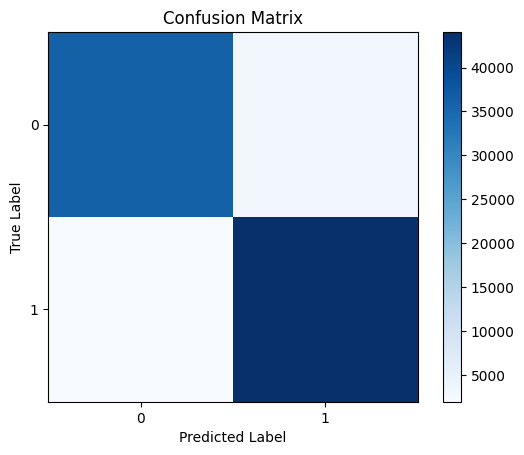


Precision: 0.9354
Recall: 0.9567
F1 Score: 0.9459

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     39116
           1       0.94      0.96      0.95     46019

    accuracy                           0.94     85135
   macro avg       0.94      0.94      0.94     85135
weighted avg       0.94      0.94      0.94     85135



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy
acc = accuracy_score(valid_labels, valid_preds)
print(f"Accuracy: {acc:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds)
print()
print("Confusion Matrix:")
print(cm)
print()

# Plot heatmap of confusion matrix
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(valid_labels, valid_preds)
recall = recall_score(valid_labels, valid_preds)
f1 = f1_score(valid_labels, valid_preds)

print()
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
classification_rep = classification_report(valid_labels, valid_preds)
print()
print("Classification Report:")
print(classification_rep)

In [ ]:
predict_texts(["that was not a bad experience of my life"])
predict_texts(["that was a bad experience of my life"])

1 (0.953) - that was not a bad experience of my life
1 (0.601) - that was a bad experience of my life


In [ ]:
x, y = collate_batch(
    [[0, TEXT_PIPELINE(text)] for text in TEST_SENTENCES]
)
model.eval()
preds = model(x)
# preds = preds.round()
preds = preds.tolist()

for pred, orig_text in zip(preds, TEST_SENTENCES):
    print(f"Text: {orig_text}")
    print(f"Prediction: {['Negative Sentiment', 'Positive Sentiment'][int(round(pred))]} ( Confidence in Prediction: {abs(round(( pred - (1 - round(pred)) ) * 100 , 2))}% )")
    print()

Text: I'm extremely disappointed with the quality of this item; it broke within a week.
Prediction: Negative Sentiment ( Confidence in Prediction: 99.99% )

Text: The customer support for this product is terrible; they were unhelpful and rude.
Prediction: Negative Sentiment ( Confidence in Prediction: 99.95% )

Text: I had high expectations for this item, but it turned out to be a total letdown.
Prediction: Negative Sentiment ( Confidence in Prediction: 98.76% )

Text: The shipping was delayed, and the packaging was damaged when the product arrived.
Prediction: Negative Sentiment ( Confidence in Prediction: 55.43% )

Text: I encountered multiple issues with this item, and the manufacturer provided no solutions.
Prediction: Positive Sentiment ( Confidence in Prediction: 74.52% )

Text: The features advertised for this product are misleading; it doesn't perform as claimed.
Prediction: Negative Sentiment ( Confidence in Prediction: 98.47% )

Text: I found this item to be overpriced for it